# Part 3: Serving

In this part you use MLRun's **serving runtime** to deploy the trained models from the previous stage a `Voting Ensemble` using **max vote** logic.  
You will also use MLRun's **Feature store** to receive the latest tag of the online **Feature Vector** we defined in the previous stage.

By the end of this tutorial you’ll learn how to:
- Define a model class to load the models, run preprocessing, and predict on the data
- Define Voting Ensemble function on top of our models
- Test the serving function locally using the `mock server`
- Deploy the function to the cluster and test it live

## Environment setup

First, make sure SciKit-Learn is installed in the correct version:

In [ ]:
!pip install -U scikit-learn==1.0.2

Restart your kernel post installing.
Secondly, since the work is done in this project scope, define the project itself for all your MLRun work in this notebook.

In [2]:
project_name = 'fraud-demo'

In [3]:
import mlrun

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2021-10-28 11:59:01,033 [info] loaded project fraud-demo from MLRun DB


## Define model class
- Load models
- Predict from the FS Online service via the `source` key

In [4]:
# mlrun: start-code

In [5]:
import numpy as np
from cloudpickle import load
from mlrun.serving.v2_serving import V2ModelServer

class ClassifierModel(V2ModelServer):
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))
        
    def predict(self, body: dict) -> list:
        """Generate model predictions from sample"""
        print(f"Input -> {body['inputs']}")
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [6]:
# mlrun: end-code

## Define a serving function

MLRun serving can produce managed real-time serverless pipelines from various tasks, including MLRun models or standard model files.
The pipelines use the Nuclio real-time serverless engine, which can be deployed anywhere.
[Nuclio](https://nuclio.io/) is a high-performance open-source serverless framework that's focused on data, I/O, and compute-intensive workloads.

The **EnrichmentVotingEnsemble** and the **EnrichmentModelRouter** router classes auto enrich the request with data from the feature store.
The router input accepts lists of inference request (each request can be a dict or list of incoming features/keys). It enriches the request with data from the specified feature vector (`feature_vector_uri`).

In many cases the features can have null values (None, NaN, Inf, ..). The `Enrichment` routers can substitute the null value with fixed or statistical value per feature. This is done through the `impute_policy` parameter, which accepts the impute policy per feature (where `*` is used to specify the default). The value can be a fixed number for constants or `$mean`, `$max`, `$min`, `$std`, `$count` for statistical values. to substitute the value with the equivalent feature stats (taken from the feature store).  

The code below performs the following steps:

- Gather ClassifierModel code from this notebook
- Define `EnrichmentVotingEnsemble` - Max-Vote based ensemble with feature enrichment and imputing
- Add the previously trained models to the ensemble

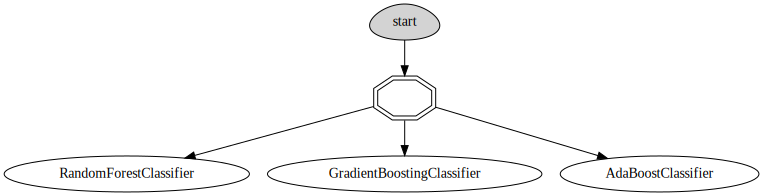

In [7]:
# Create the serving function from the code above
serving_fn = mlrun.code_to_function('transaction-fraud', kind='serving', image="mlrun/mlrun")

serving_fn.set_topology('router', 'mlrun.serving.routers.EnrichmentVotingEnsemble', name='VotingEnsemble',
                        feature_vector_uri="transactions-fraud-short", impute_policy={"*": "$mean"})

model_names = [
'RandomForestClassifier',
'GradientBoostingClassifier',
'AdaBoostClassifier'
]

for i, name in enumerate(model_names, start=1):
    serving_fn.add_model(name, class_name="ClassifierModel", model_path=project.get_artifact_uri(f"training_model#{i}:latest"))

# Plot the ensemble configuration
serving_fn.spec.graph.plot()

## Test the server locally

Before deploying the serving function, test it in the current notebook and check the model output.

In [8]:
# Create a mock server from the serving function
local_server = serving_fn.to_mock_server()

> 2021-10-28 11:59:11,260 [info] model RandomForestClassifier was loaded
> 2021-10-28 11:59:11,306 [info] model GradientBoostingClassifier was loaded
> 2021-10-28 11:59:11,350 [info] model AdaBoostClassifier was loaded


In [9]:
# Choose an id for the test
sample_id = 'C76780537'

model_inference_path = '/v2/models/infer'

# Send our sample ID for prediction
local_server.test(path=model_inference_path,
            body={'inputs': [[sample_id]]})

# Notice the input vector is printed 3 times (once per child model) and is enriched with data from the feature store

Input -> [[14.68, 14.68, 1.0, 14.68, 70.81]]
Input -> [[14.68, 14.68, 1.0, 14.68, 70.81]]
Input -> [[14.68, 14.68, 1.0, 14.68, 70.81]]


{'id': '757c736c985a4c42b3ebd58f3c50f1b2',
 'model_name': 'VotingEnsemble',
 'outputs': [0],
 'model_version': 'v1'}

### Accessing the real-time feature vector directly

You can also directly query the feature store values using the `get_online_feature_service` method. This method is used internally in the EnrichmentVotingEnsemble router class

In [10]:
import mlrun.feature_store as fstore

# Create the online feature service
svc = fstore.get_online_feature_service('transactions-fraud-short:latest', impute_policy={"*": "$mean"})

# Get sample feature vector
sample_fv = svc.get([{'source': sample_id}])
sample_fv

[{'amount_max_2h': 14.68,
  'amount_max_12h': 70.81,
  'amount_sum_2h': 14.68,
  'amount_count_2h': 1.0,
  'amount_avg_2h': 14.68}]

## Deploying the function on the kubernetes cluster

You can now deploy the function. Once it's deployed you get a function with an http trigger that can be called from other locations.

In [11]:
import os

# Enable model monitoring
serving_fn.set_tracking()
project.set_model_monitoring_credentials(os.getenv('V3IO_ACCESS_KEY'))

# Deploy the serving function
serving_fn.deploy()

> 2021-10-28 11:59:17,554 [info] Starting remote function deploy
2021-10-28 11:59:17  (info) Deploying function
2021-10-28 11:59:17  (info) Building
2021-10-28 11:59:17  (info) Staging files and preparing base images
2021-10-28 11:59:17  (info) Building processor image
2021-10-28 11:59:19  (info) Build complete
2021-10-28 11:59:25  (info) Function deploy complete
> 2021-10-28 11:59:25,657 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['default-tenant.app.yh38.iguazio-cd2.com:32287']}


'http://default-tenant.app.yh38.iguazio-cd2.com:32287'

## Test the server

Test the serving function and examine the model output.

In [12]:
# Choose an id for the test
sample_id = 'C76780537'

model_inference_path = '/v2/models/infer'

# Send the sample ID for prediction
serving_fn.invoke(path=model_inference_path,
                  body={'inputs': [[sample_id]]})

> 2021-10-28 11:59:25,722 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/infer'}


{'id': '4b9c4914-964f-4bd5-903d-c4885ed7c090',
 'model_name': 'VotingEnsemble',
 'outputs': [0],
 'model_version': 'v1'}

You can also directly query the feature store values, which are used in the enrichment.

### Simulate incoming data

In [13]:
# Load the dataset
data = mlrun.get_dataitem('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv').as_df()

# Sample 50k lines
data = data.sample(50000)

# keys
sample_ids = data['source'].to_list()

In [14]:
from random import choice, uniform
from time import sleep

# Sending random requests
for _ in range(4000):
    data_point = choice(sample_ids)
    try:
        resp = serving_fn.invoke(path=model_inference_path, body={'inputs': [[data_point]]})
        print(resp)
        sleep(uniform(0.2, 1.7))
    except OSError:
        pass

> 2021-10-28 12:00:23,079 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/infer'}
{'id': '6b813638-e9ef-4e92-85c8-cfbd0b74fe32', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2021-10-28 12:00:23,857 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/infer'}
{'id': 'f84bf2ec-a718-4e90-a7d5-fe08e254f3c8', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2021-10-28 12:00:24,545 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/infer'}
{'id': '7bb023f7-edbc-47a6-937b-4a15c8380b74', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2021-10-28 12:00:24,921 [info] invoking function: {'method': 'POST', 'path': 'http://nucl